<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Présentation-du-projet" data-toc-modified-id="Présentation-du-projet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Présentation du projet</a></span></li><li><span><a href="#Péparation-des-données" data-toc-modified-id="Péparation-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Péparation des données</a></span><ul class="toc-item"><li><span><a href="#Visualisation" data-toc-modified-id="Visualisation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualisation</a></span></li></ul></li><li><span><a href="#GAN" data-toc-modified-id="GAN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GAN</a></span><ul class="toc-item"><li><span><a href="#Generator" data-toc-modified-id="Generator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminateur" data-toc-modified-id="Discriminateur-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Discriminateur</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Résultats-par-GAN" data-toc-modified-id="Résultats-par-GAN-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Résultats par GAN</a></span></li></ul></li><li><span><a href="#AutoEncoder" data-toc-modified-id="AutoEncoder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>AutoEncoder</a></span><ul class="toc-item"><li><span><a href="#Modification-du-dataset" data-toc-modified-id="Modification-du-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Modification du dataset</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#saving-our-training" data-toc-modified-id="saving-our-training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>saving our training</a></span><ul class="toc-item"><li><span><a href="#Résultats-par-AE" data-toc-modified-id="Résultats-par-AE-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Résultats par AE</a></span></li></ul></li><li><span><a href="#TEST-ZONE" data-toc-modified-id="TEST-ZONE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TEST ZONE</a></span></li></ul></div>

# Présentation du projet


Dans ce projet, on va utiliser un GAN et un AE sur la base de données MNIST et les comparer.


# Péparation des données

In [1]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F


# torchsummary and torchvision
from torchsummary import summary
import torchvision
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time


CUDA = False and torch.cuda.is_available()
seed = 1

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


dataset = datasets.MNIST(root='data', download=True,
                     transform=torchvision.transforms.Compose([
                     torchvision.transforms.Resize(64),
                     torchvision.transforms.ToTensor(),
                     torchvision.transforms.Normalize((0.5,), (0.5,))
                     ]))
# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 104360372.21it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85608264.19it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 51925784.58it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21846936.66it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
#pip3 install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


## Visualisation

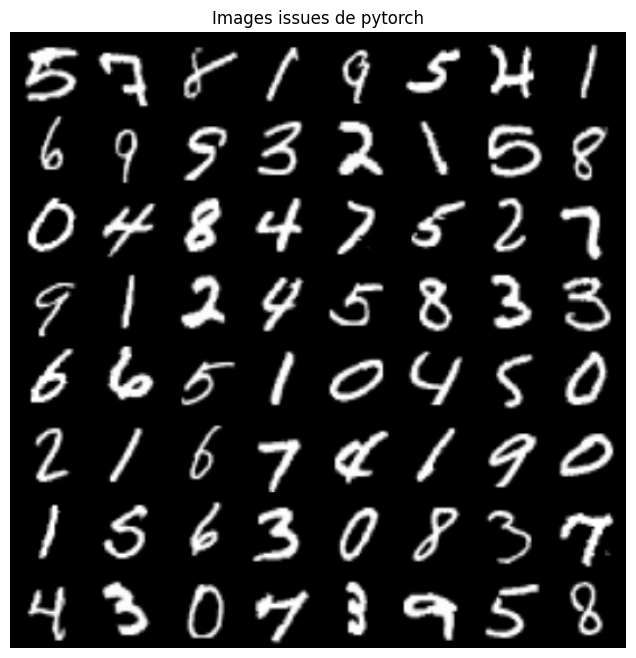

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Images issues de pytorch")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


<ipython-input-5-6ea73ca35080>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(j+1, n, i + 1 +j*n)


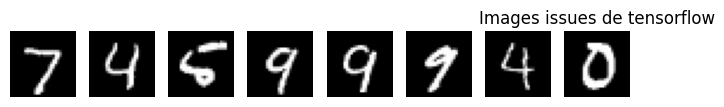

In [5]:
n = 8

plt.figure(figsize=(n, n))

for i in range(n):
    for j in range(n):
        ax = plt.subplot(j+1, n, i + 1 +j*n)
        plt.imshow(x_test[4*i].reshape(28, 28))
        plt.gray()
        plt.axis("off")
plt.title("Images issues de tensorflow")
plt.show()

# GAN

## Generator


In [30]:
latent_dim = 64
# Augmenter la taille du lot
batch_size = 128

# Réduire le taux d'apprentissage
learning_rate = 0.0001

# Architecture du générateur
generator = tf.keras.Sequential([
    layers.Dense(7*7*256, activation='relu', input_shape=(latent_dim,)),
    layers.Reshape((7, 7, 256)),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(128, 3, activation='relu', strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(1, 3, activation='sigmoid', strides=2, padding='same')
])



## Discriminateur

In [31]:
# Architecture du discriminateur
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, 3, activation=tf.nn.leaky_relu, input_shape=(28, 28, 1)),
    layers.Conv2D(128, 3, activation=tf.nn.leaky_relu, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)


# Compilation des modèles
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')
discriminator.trainable = False
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')


## Training

In [34]:
epochs = 5
for epoch in range(epochs):
    for _ in range(len(x_train) // batch_size):
        noise = tf.random.normal([batch_size, latent_dim])
        generated_images = generator(noise)

        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

        x_combined = tf.concat([real_images, generated_images], axis=0)
        y_combined = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_combined, y_combined)

        noise = tf.random.normal([batch_size, latent_dim])
        y_mislabeled = tf.ones((batch_size, 1))

        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_mislabeled)

    print(f"Epoch {epoch+1}, d_loss: {d_loss}, g_loss: {g_loss}")


Epoch 1, d_loss: 0.16456981003284454, g_loss: 8.672286987304688
Epoch 2, d_loss: 0.12078989297151566, g_loss: 5.220453262329102
Epoch 3, d_loss: 0.1534077227115631, g_loss: 6.1326904296875
Epoch 4, d_loss: 0.0862400084733963, g_loss: 0.28679874539375305
Epoch 5, d_loss: 0.08876476436853409, g_loss: 0.006607966497540474


## Résultats par GAN

<ipython-input-35-531775b3561a>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(j+1, n, i + 1 +j*n)


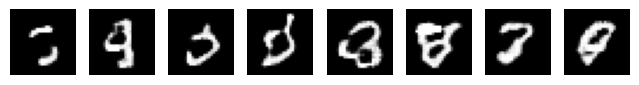

In [35]:
# Génération d'images avec le GAN
noise = tf.random.normal([10, latent_dim])
generated_images = generator(noise)

# Affichage des images générées

n = 8

plt.figure(figsize=(n, n))
for i in range(n):
    for j in range(n):
        ax = plt.subplot(j+1, n, i + 1 +j*n)
        plt.imshow(generated_images[i].numpy().reshape(28, 28))
        plt.gray()
        plt.axis("off")
plt.show()

# AutoEncoder
## Modification du dataset

In [ ]:
import torchvision.transforms as transforms

# Define a new transform to convert PIL images to arrays
transform_to_array = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset with the new transform
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform_to_array)
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform_to_array)

# Split the training data into training and validation sets
m = len(train_data)
train_data, val_data = torch.utils.data.random_split(train_data, [int(m - m * 0.2), int(m * 0.2)])

# Create data loaders with the new datasets
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True))

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim))

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True))

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
            padding=1, output_padding=1))

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
criterion = torch.nn.MSELoss()
lr= 0.001

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

#encoder.load_state_dict(torch.load("MODEL/encoder"))
encoder.eval()
print(encoder)

#decoder.load_state_dict(torch.load("MODEL/decoder"))
decoder.eval()
print(decoder)


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kern

## Training

In [ ]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i, (image_batch, _) in enumerate(dataloader):
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if i % 100 == 0:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

> LONG À COMPILER !!!

In [ ]:
num_epochs = 2
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device, train_loader,criterion,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,criterion)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)

	 partial train loss (single batch): 0.193562
	 partial train loss (single batch): 0.088449

 EPOCH 1/2 	 train loss 0.09943841397762299 	 val loss 0.06463117897510529
	 partial train loss (single batch): 0.065242
	 partial train loss (single batch): 0.056105

 EPOCH 2/2 	 train loss 0.0569976344704628 	 val loss 0.05328245460987091


# saving our training
torch.save(encoder.state_dict(), "MODEL/encoder")
torch.save(decoder.state_dict(), "MODEL/decoder")

## Résultats par AE

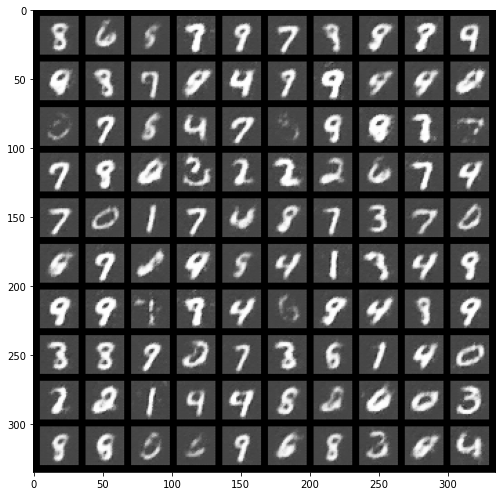

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        latent = encoder(images)
        latent = latent.cpu()

        mean = latent.mean(dim=0)
        #print(mean)
        std = (latent - mean).pow(2).mean(dim=0).sqrt()
        #print(std)

        # sample latent vectors from the normal distribution
        latent = torch.randn(128, d)*std + mean

        # reconstruct images from the random latent vectors
        latent = latent.to(device)
        img_recon = decoder(latent)
        img_recon = img_recon.cpu()

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
plt.show()

# TEST ZONE